## Задание 4.
Рассмотрим датасет по предсказанию года создания песни по числовым признакам.
Информацию о датасете можно найти здесь: 
- https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#
- http://labrosa.ee.columbia.edu/millionsong
- https://en.wikipedia.org/wiki/Timbre

**Ссылка**: https://www.kaggle.com/t/c55b0b2354bd4ca5ac83fe5ed8b3eb92

Мы используем поднабор этого датасета. Пожалуйста, не используйте исходный датасет для читинга, за это получите 0 за ВООБЩЕ всю домашку. Это задание организовано с помощью соревнования на kaggle.
Попробуйте обучить нейронную сеть (используя линейные и другие слои, возможную нормализацию и активации). Можете использовать любые методы предобработки данных и фокусы, 
кроме ансамблирования и использования сторонних источников ДАННЫХ.
- Задание обязательно, базовое максимальное число баллов - 6. 
- Топ 25% получат +3 балла, топ 50 +2 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Обучите модель, используя ваш кастомный оптимизатор. Это даст еще 1 балл. Покажите, изменилось ли что-то.
- При решении задачи можно использовать любые встренные в torch модули (nn, optim, transforms, etc)
- Можно использовать numpy, sklearn, pandas ТОЛЬКО для предобработки и постобработки решения (сборки сабмишена). Для самой модели можно использовать только torch.
- При переобучении можно добавить dropout, batchnorm итд. 

# Предобработка
[Источник вдохновления](https://www.kaggle.com/code/raghav1810/release-year-prediction-on-msd-using-neural-nets)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.model_selection import train_test_split        
from keras.utils import to_categorical                      # Стараемся привести количество
from sklearn.preprocessing import StandardScaler            # Делаем из данных нормально распределенные значения
from sklearn.decomposition import PCA                       # Метод главных компонент
from sklearn.model_selection import KFold                   # Кросс-валидация 
from sklearn.preprocessing import OneHotEncoder

df_x = pd.read_csv("../../datasets/YearPredictionMSD/train_x.csv", index_col="id") #, sep=","
df_y = pd.read_csv("../../datasets/YearPredictionMSD/train_y.csv", index_col="id")
df_exam = pd.read_csv("../../datasets/YearPredictionMSD/test_x.csv", index_col="id")
df = pd.merge(df_x, df_y, left_index=True, right_index=True)
df = df[df["year"] > 1960]
df.info()
df_exam

<class 'pandas.core.frame.DataFrame'>
Index: 13873 entries, 133081 to 154731
Data columns (total 91 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TimbreAvg1          13873 non-null  float64
 1   TimbreAvg2          13873 non-null  float64
 2   TimbreAvg3          13873 non-null  float64
 3   TimbreAvg4          13873 non-null  float64
 4   TimbreAvg5          13873 non-null  float64
 5   TimbreAvg6          13873 non-null  float64
 6   TimbreAvg7          13873 non-null  float64
 7   TimbreAvg8          13873 non-null  float64
 8   TimbreAvg9          13873 non-null  float64
 9   TimbreAvg10         13873 non-null  float64
 10  TimbreAvg11         13873 non-null  float64
 11  TimbreAvg12         13873 non-null  float64
 12  TimbreCovariance1   13873 non-null  float64
 13  TimbreCovariance2   13873 non-null  float64
 14  TimbreCovariance3   13873 non-null  float64
 15  TimbreCovariance4   13873 non-null  float64
 16  Tim

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
id,,,,,,,,,,,,,,,,,,,,,
3416,44.69970,7.96998,-15.16859,-15.88686,1.58073,-6.23497,-11.59792,-11.71405,4.32023,-8.56689,...,14.60884,16.70871,22.73881,12.92728,5.35942,33.01436,-54.54467,-2.53457,19.44396,8.74708
18991,50.75305,49.55872,30.33403,-13.05537,-34.51915,-21.38223,1.07836,-7.79340,15.95731,8.97746,...,-11.98495,56.64278,-58.77229,44.02523,-6.08207,127.27562,53.55449,-21.83976,-46.89782,-12.17533
11105,39.41930,-38.69590,-22.15177,-4.07812,-19.06480,-11.15927,14.99402,2.75120,2.32396,4.29177,...,11.35409,-90.24540,-123.84976,65.31781,8.30738,-148.93180,-162.58971,-6.31094,-116.44189,-7.85765
18902,46.67711,56.98689,-22.63047,-10.90758,4.69374,15.66760,-7.25281,13.54849,-1.37275,16.10065,...,-5.77311,-257.63385,32.63454,-117.37477,3.12995,61.86812,-246.54612,2.13762,27.88064,-13.57062
18958,40.14486,-20.88083,-7.30665,-1.21121,27.23754,-22.98837,-1.81173,-2.44144,0.06913,-3.55877,...,24.11829,262.05281,190.80106,224.96182,8.19406,-44.09140,-14.54322,-7.52484,-57.88128,0.91497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15293,39.44790,-64.93194,-0.83019,-5.25472,-8.50352,-9.31121,11.91198,-8.60336,-7.33098,-12.36373,...,137.83066,12.74870,-126.15534,-127.67152,7.90602,-5.43619,-218.05441,7.37368,61.07918,38.02987
7469,37.40456,-60.09514,19.40282,-2.78752,-22.26984,-3.78960,8.27761,-7.95887,3.72717,-2.46880,...,0.27233,-92.83365,19.10577,12.88895,5.68489,106.68987,-137.49480,-4.69688,9.18971,-11.15737
6586,43.53168,-122.30174,133.79228,29.69593,-72.74356,6.84467,-18.07552,0.23652,36.78711,4.75939,...,33.17404,-110.63114,75.84926,56.66991,-4.85303,-53.42711,143.93005,3.30087,-145.13657,9.38941


In [2]:
df.describe()
#df.to_csv("df_describe()", sep='\t', index = False)


,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78,year
count,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,...,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000,13873.000000
mean,43.449878,2.006303,8.195254,1.345798,-6.523309,-9.632579,-2.124649,-1.686731,3.545596,1.893017,...,-71.660304,40.538860,37.711971,0.186837,17.533011,-28.472681,4.500802,17.692925,1.196460,1998.789808
std,6.042963,51.232388,35.550501,16.581387,22.768888,12.837100,14.631644,8.018816,10.557856,6.598343,...,171.942860,119.616619,96.379805,16.179512,115.720396,180.032571,13.592215,185.368284,22.044069,10.132197
min,7.199890,-302.031900,-257.525600,-120.723150,-142.160680,-60.198620,-100.602550,-51.443820,-75.539550,-31.344160,...,-1976.846950,-791.832320,-1237.931680,-227.608010,-2678.193680,-3059.906060,-100.618700,-5000.654060,-286.031200,1961.000000
25%,40.026120,-25.027470,-11.795090,-8.451500,-20.740640,-18.580810,-10.515420,-6.417530,-2.563330,-2.443910,...,-138.159940,-21.855540,-4.427600,-6.958870,-32.246520,-100.865750,-2.553870,-60.266070,-8.881520,1995.000000
50%,44.321480,9.117410,10.124200,-0.571230,-5.871690,-11.357680,-1.918640,-1.540820,3.658170,1.764450,...,-52.684880,28.728750,33.497840,0.802940,15.524730,-21.900730,3.025110,6.990210,-0.064470,2002.000000
75%,47.870850,36.822380,29.401540,9.022020,7.794290,-2.349890,6.788440,3.066090,9.925290,6.248400,...,14.602710,88.273210,78.609040,8.426690,66.403840,50.301150,9.921010,86.067100,9.595730,2006.000000
max,57.408630,240.617010,318.868960,143.841600,142.305480,68.300090,147.965260,52.331120,78.149440,36.596180,...,1081.951340,1473.745210,1458.580210,199.121500,1620.749740,1879.332480,352.359540,3165.372860,245.209770,2011.000000


In [3]:
#corr_matrix = df.corr()
#corr_matrix

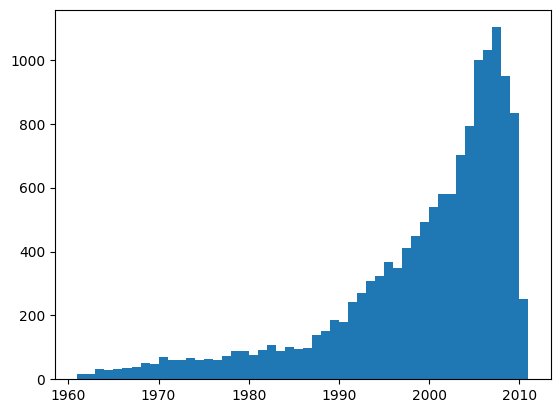

In [4]:

a = plt.hist(df["year"], bins=50, )
#a[1]
#nsongs = {}
#for y in range(1960,2012):
#    nsongs[y] = len(df[df.year==y])
#yrs = range(1960,2011)
#values = [nsongs[y] for y in yrs]
#plt.bar(yrs, values, align='center')
#plt.xlabel("Year")
#plt.ylabel("Number of songs")
#b = a[0].sum() /  a[0]
#print((df["year"] > 1961))
# 13873

#yrs = range(1960,2011)
#values = [nsongs[y] for y in yrs]
#plt.bar(yrs, values, align='center')
#plt.xlabel("Year")
#plt.ylabel("Number of songs")

In [5]:
df_2 = df.copy()
df_2["target"] = 0

interval_num = 19

counter = interval_num

k=0
for y in range(2012, 1959, -1):
    l = len(df_2[df_2.year==y])
    k += l
    
    if k >= len(df_2) / interval_num:
        df_2.loc[(df_2.year >=y) & (df_2.target == 0), "target"] = counter
        counter-=1
        k=0

df_2.loc[(df_2.year >= 1959) & (df_2.target == 0), "target"] = counter



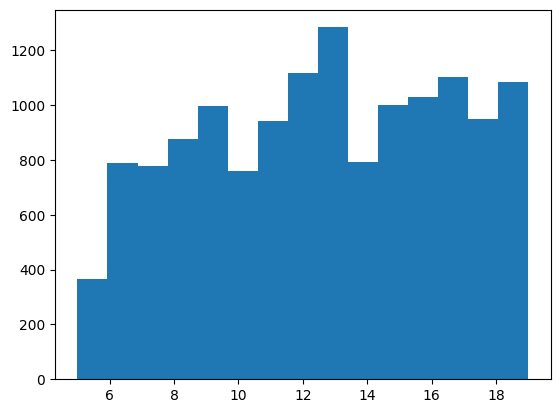

In [6]:
a = plt.hist(df_2["target"], bins=15)


In [7]:
df_2[df_2["target"] == df_2["target"].min()].describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78,year,target
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,...,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.0
mean,40.460913,-13.471929,19.942557,-0.857678,-6.529586,-2.817605,-6.563523,-1.866281,5.055825,0.220766,...,51.952525,36.469774,-1.262772,29.067433,-36.685195,2.707228,24.020534,3.425362,1966.599455,5.0
std,5.192827,48.576570,32.980738,13.673682,22.516670,10.704343,13.182806,6.949709,11.843916,5.442652,...,103.987681,80.560717,13.097029,90.879006,162.727222,10.600536,163.215430,17.654717,2.750122,0.0
min,20.651550,-202.519780,-81.943130,-45.043920,-72.133070,-40.999600,-44.904530,-24.505670,-36.239730,-19.797420,...,-306.565060,-311.160310,-52.308760,-381.420000,-706.958620,-36.362510,-944.238690,-70.621910,1961.000000,5.0
25%,37.518625,-41.248460,1.803290,-8.501600,-21.490325,-10.050575,-14.500775,-5.916690,-3.273215,-3.704350,...,-8.172215,-10.196390,-8.106000,-17.991920,-117.146165,-2.174240,-60.197780,-5.611810,1964.000000,5.0
50%,40.914540,-10.484910,20.065750,-1.003190,-6.395280,-3.268060,-6.523430,-1.645890,5.735580,0.214060,...,38.379680,35.505830,-0.264140,28.900550,-21.730990,2.470250,20.546140,2.016720,1967.000000,5.0
75%,44.379055,24.472300,40.415765,7.135850,9.826105,4.023225,1.974950,2.216095,13.925460,3.776050,...,107.624045,79.773805,5.875700,69.918840,56.457885,7.564775,95.183870,12.453005,1969.000000,5.0
max,53.551050,99.295250,123.282130,36.322600,58.681370,32.077210,42.724890,18.847700,45.777550,15.982840,...,412.888870,332.525830,48.746360,477.536490,521.897490,72.450810,925.895590,74.155710,1970.000000,5.0


In [8]:
df_2["target"].value_counts()

target
13    1284
12    1119
17    1102
19    1086
16    1031
15    1001
9      998
18     951
11     942
8      875
14     792
6      788
7      779
10     758
5      367
Name: count, dtype: int64

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(df_2.drop(["target", "year"],axis=1), df_2["target"], test_size=0.2)

### TO-DO: убрать выбросы

In [10]:
#sns.boxplot(x=X_train["1"])
#plt.stairs(counts, bins)

#counts, bins = np.histogram(X_train["28"])
#plt.hist(bins[:-1], bins, weights=counts)
#Y_train

In [11]:
scaler = StandardScaler()
# Нормализация для обучаемого набора данных
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)

# Нормализация для тестового набора данных
scaler.fit(X_test)
X_test_norm = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_norm, columns=X_test.columns)

Y_train = pd.DataFrame(Y_train, columns=["target"])
Y_test = pd.DataFrame(Y_test, columns=["target"])

### TO-DO Сделать метод главных компонент

In [12]:
#pca = PCA(.90)
#pca.fit(X_train)
#pca.n_components_


#X_train_proc = torch.tensor(pca.transform(X_train_std), dtype=torch.float)
#X_test_proc = torch.tensor(pca.transform(X_test_std), dtype=torch.float)

### TO-DO: Сделать промежутки для классов

In [13]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(handle_unknown='ignore')
#print(enc.fit(df_2[["target"]]).categories_)
#df_y = enc.fit_transform(df_2[["target"]]) #.toarray()
#le.transform([1, 1, 2, 6])

#Y_train["year"] = Y_train["year"] - min(Y_train["year"])
#Y_test["year"] = Y_test["year"] - min(Y_test["year"])

#Y_train["year"]/=max(Y_train["year"])
#Y_test["year"]/=max(Y_test["year"])


In [14]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y_train)
Y_train = enc.transform(Y_train).toarray()
Y_test = enc.transform(Y_test).toarray()
#Y_train = pd.get_dummies(Y_train)
#Y_test = pd.get_dummies(Y_test)

Y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Нейросеть
[Источник вдохновления](https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/)

Попробуем использовать сверточную нейронную сеть, предварительно разделив входные признаки на 2 канала: TimbreAvg (1-12) и TimbreCovariance (1-78)

In [15]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe_X, dataframe_Y):
        self.dataframe_X = dataframe_X
        self.dataframe_Y = dataframe_Y

    def __len__(self):
        return len(self.dataframe_X)

    def __getitem__(self, idx):
        X = torch.tensor(self.dataframe_X.iloc[idx], dtype=torch.float)
        Y = torch.tensor(self.dataframe_Y[idx], dtype=torch.float)
        return X, Y

train_data = CustomDataset(X_train, Y_train)
test_data = CustomDataset(X_test, Y_test)

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

train_labels

/tmp/ipykernel_26058/1562155217.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = torch.tensor(self.dataframe_X.iloc[idx], dtype=torch.float)


tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
class MySeparator(nn.Module):
    ''' Разделяет dataset на TimbreAvg [12] и TimbreCovariance [78] '''
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __call__(self, tensor: torch.Tensor, *args, **kwargs):
        #print(tensor)
        return tensor[0, :12],tensor[0, 12:90] 
        #return tensor.view(tensor.size(0), -1)

In [17]:
class NeuralNetwork(nn.Module):
    '''
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
        self.flatten = MyFlatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    '''
    # Возможно использование данной модели представляет из себя не лучшее решение
    def __init__(self):
        super().__init__()
        self.separator = MySeparator()

        self.Cov_model = nn.Sequential(
            nn.Linear(78, 22),
            nn.ReLU(),

        )

        self.Avg_model = nn.Sequential(
            nn.Linear(12, 8),
            nn.ReLU(),
        )
        
        self.Exit_model = nn.Sequential(
            nn.Linear(30, 15),
            nn.ReLU(),
            #nn.Softmax(),
            nn.Linear(15, 15),
#            nn.Softmax(),

        )
        

    def forward(self, x):
        TimbreAvg, TimbreCovariance = self.separator(x)
        TimbreAvg_out = self.Avg_model(TimbreAvg)
        TimbreCovariance_out = self.Cov_model(TimbreCovariance)

        pre_exit = torch.concat([TimbreAvg_out, TimbreCovariance_out])

        logits = self.Exit_model(pre_exit)
        return logits.unsqueeze(0)

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (separator): MySeparator()
  (Cov_model): Sequential(
    (0): Linear(in_features=78, out_features=22, bias=True)
    (1): ReLU()
  )
  (Avg_model): Sequential(
    (0): Linear(in_features=12, out_features=8, bias=True)
    (1): ReLU()
  )
  (Exit_model): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
  )
)


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#loss_fn = nn.MSELoss()
loss_fn = nn.CrossEntropyLoss()


In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss, num_correct = 0, 0

    model.train()

    #min_loss = float("inf")
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs, targets

        # Compute prediction error
        preds = model(inputs.float())

        num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
        #print(preds)
        
        loss = loss_fn(preds, targets)
        #print(preds, targets)

        #if loss < min_loss:
        #    min_loss = loss
        train_loss+=loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if batch_idx % 100 == 0:
            #loss, current = loss.item(), (batch_idx + 1) * len(preds)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    #print(f'Min loss: {min_loss:>5f}')
    train_loss /= num_batches
    num_correct /= size
    
    print(f"Train Error: \n Accuracy: {(100*num_correct):>0.1f}%, Avg loss: {train_loss:>8f}")

    #train_loss /= num_batches

    return 100*num_correct, train_loss

In [20]:
from sklearn.metrics import precision_score, recall_score

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs, targets
            preds = model(inputs.float())
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
            test_loss += loss_fn(preds, targets).item()
            
            # Store predictions and targets for metrics computation
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss /= num_batches
    num_correct /= size

    # Compute precision and recall
#    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
#    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
#    precision = precision_score(all_targets, all_preds, average='micro')
#    recall = recall_score(all_targets, all_preds, average='micro')

    print(f"Test Error: \n Accuracy: {(100*num_correct):>0.1f}%, Avg loss: {test_loss:>8f}")
#    print(f"Precision: {100*precision:>0.1f}%, Recall: {100*recall:>0.1f}% \n")
    return num_correct*100, test_loss

In [21]:
epochs = 100
Loss_train = []
Loss_test = []
Accuracy_test = []
Accuracy_train = []


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # ваш код
    

    train_accuracy, train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_accuracy, test_loss = test(test_dataloader, model, loss_fn)

    Accuracy_train.append(train_accuracy)
    Loss_train.append(train_loss)

    Accuracy_test.append(test_accuracy)
    Loss_test.append(test_loss)


Epoch 1
-------------------------------


/tmp/ipykernel_26058/1562155217.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = torch.tensor(self.dataframe_X.iloc[idx], dtype=torch.float)


Train Error: 
 Accuracy: 5.2%, Avg loss: 2.575206
Test Error: 
 Accuracy: 0.6%, Avg loss: 2.467196
Epoch 2
-------------------------------
Train Error: 
 Accuracy: 8.0%, Avg loss: 2.467912
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.449335
Epoch 3
-------------------------------
Train Error: 
 Accuracy: 16.5%, Avg loss: 2.434304
Test Error: 
 Accuracy: 13.5%, Avg loss: 2.452320
Epoch 4
-------------------------------
Train Error: 
 Accuracy: 37.1%, Avg loss: 2.411262
Test Error: 
 Accuracy: 27.5%, Avg loss: 2.453414
Epoch 5
-------------------------------
Train Error: 
 Accuracy: 44.2%, Avg loss: 2.397462
Test Error: 
 Accuracy: 39.6%, Avg loss: 2.463670
Epoch 6
-------------------------------
Train Error: 
 Accuracy: 55.5%, Avg loss: 2.387389
Test Error: 
 Accuracy: 54.5%, Avg loss: 2.472061
Epoch 7
-------------------------------
Train Error: 
 Accuracy: 58.1%, Avg loss: 2.377264
Test Error: 
 Accuracy: 68.0%, Avg loss: 2.478720
Epoch 8
-------------------------------
Train Error: 
 A

KeyboardInterrupt: 

In [22]:
Loss_train = torch.tensor(Loss_train).numpy()
Loss_test = torch.tensor(Loss_test).numpy()
Accuracy_train = torch.tensor(Accuracy_train).numpy()
Accuracy_test = torch.tensor(Accuracy_test).numpy()


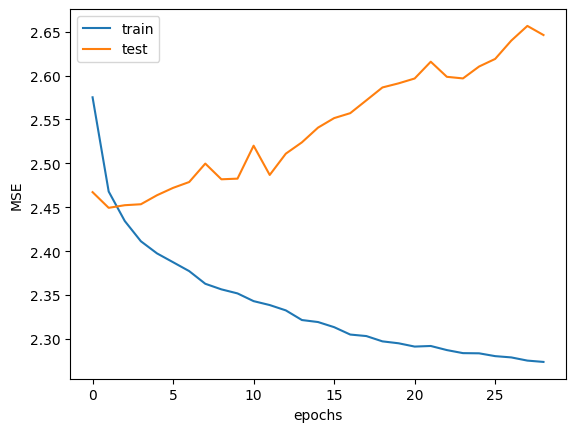

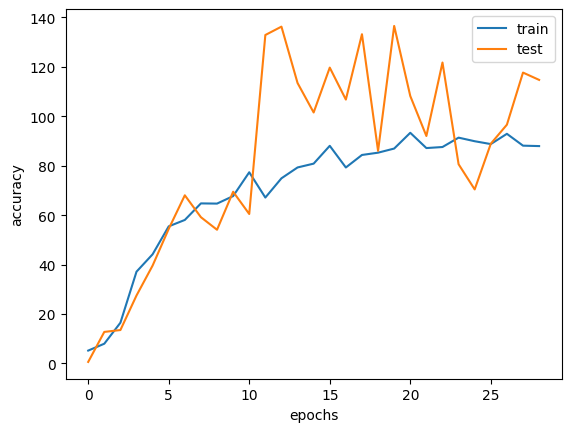

In [23]:
import matplotlib.pyplot as plt
 
plt.plot(Loss_train, label="train")
plt.plot(Loss_test, label="test")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

plt.plot(Accuracy_train, label="train")
plt.plot(Accuracy_test, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [29]:
df_exam

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
id,,,,,,,,,,,,,,,,,,,,,
3416,44.69970,7.96998,-15.16859,-15.88686,1.58073,-6.23497,-11.59792,-11.71405,4.32023,-8.56689,...,14.60884,16.70871,22.73881,12.92728,5.35942,33.01436,-54.54467,-2.53457,19.44396,8.74708
18991,50.75305,49.55872,30.33403,-13.05537,-34.51915,-21.38223,1.07836,-7.79340,15.95731,8.97746,...,-11.98495,56.64278,-58.77229,44.02523,-6.08207,127.27562,53.55449,-21.83976,-46.89782,-12.17533
11105,39.41930,-38.69590,-22.15177,-4.07812,-19.06480,-11.15927,14.99402,2.75120,2.32396,4.29177,...,11.35409,-90.24540,-123.84976,65.31781,8.30738,-148.93180,-162.58971,-6.31094,-116.44189,-7.85765
18902,46.67711,56.98689,-22.63047,-10.90758,4.69374,15.66760,-7.25281,13.54849,-1.37275,16.10065,...,-5.77311,-257.63385,32.63454,-117.37477,3.12995,61.86812,-246.54612,2.13762,27.88064,-13.57062
18958,40.14486,-20.88083,-7.30665,-1.21121,27.23754,-22.98837,-1.81173,-2.44144,0.06913,-3.55877,...,24.11829,262.05281,190.80106,224.96182,8.19406,-44.09140,-14.54322,-7.52484,-57.88128,0.91497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15293,39.44790,-64.93194,-0.83019,-5.25472,-8.50352,-9.31121,11.91198,-8.60336,-7.33098,-12.36373,...,137.83066,12.74870,-126.15534,-127.67152,7.90602,-5.43619,-218.05441,7.37368,61.07918,38.02987
7469,37.40456,-60.09514,19.40282,-2.78752,-22.26984,-3.78960,8.27761,-7.95887,3.72717,-2.46880,...,0.27233,-92.83365,19.10577,12.88895,5.68489,106.68987,-137.49480,-4.69688,9.18971,-11.15737
6586,43.53168,-122.30174,133.79228,29.69593,-72.74356,6.84467,-18.07552,0.23652,36.78711,4.75939,...,33.17404,-110.63114,75.84926,56.66991,-4.85303,-53.42711,143.93005,3.30087,-145.13657,9.38941


In [34]:
scaler = StandardScaler()
scaler.fit(df_exam)
df_exam_norm = scaler.transform(df_exam)
df_exam = pd.DataFrame(df_exam_norm, columns=df_exam.columns, index=df_exam.index)


In [53]:
#df_exam
df_exam_exit = pd.DataFrame(0, columns=["class"], index=df_exam.index)
df_exam_exit
#df_exam_exit.loc[18991] = 5
#df_exam_exit


,class
id,
3416,0
18991,0
11105,0
18902,0
18958,0
...,...
15293,0
7469,0
6586,0


In [54]:
with torch.no_grad():
    for index, row in df_exam.iterrows():
        data = torch.tensor(row, dtype=torch.float)
        data = data.unsqueeze(0)
        #print(model(data))
        preds = model(data)
        class_num = preds.argmax(1)
        df_exam_exit.loc[index] = class_num.item()
        #print(class_num)

/tmp/ipykernel_26058/728194370.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row, dtype=torch.float)


In [58]:
df_exam_exit
df_exam_exit_2 = pd.DataFrame(0, columns=["year"], index=df_exam.index)


In [65]:
df_exam_exit

,class
id,
3416,8
18991,14
11105,4
18902,8
18958,11
...,...
15293,8
7469,3
6586,0


In [67]:
for year_class in df_2["target"].unique():
    df_exam_exit_2.loc[df_exam_exit[df_exam_exit["class"] == year_class].index] = df_2[df_2["target"] == year_class]["year"].median()
    
    print(year_class)

12
16
8
10
19
6
9
13
11
15
5
17
7
14
18


In [73]:
df_exam_exit_2["year"].unique()

array([1991, 2004, 1940, 1999, 1977, 2001, 2003,    0, 1985, 1967, 1997,
       1994])

In [74]:
df_exam_exit_2.loc[df_exam_exit[df_exam_exit["class"] == 4].index] = 1955

In [75]:
df_exam_exit_2["year"].unique()

array([1991, 2004, 1950, 1999, 1977, 2001, 2003,    0, 1985, 1967, 1997,
       1994])

In [76]:
df_exam_exit_2.loc[df_exam_exit[df_exam_exit["class"] == 3].index] = 1950

In [77]:
df_exam_exit_2["year"].unique()

array([1991, 2004, 1950, 1999, 1977, 2001, 2003,    0, 1940, 1985, 1967,
       1997, 1994])

In [78]:
df_exam_exit_2.loc[df_exam_exit[df_exam_exit["class"] == 2].index] = 1945

In [79]:
df_exam_exit_2["year"].unique()

array([1991, 2004, 1950, 1999, 1977, 2001, 2003,    0, 1940, 1985, 1930,
       1967, 1997, 1994])

In [80]:
df_exam_exit_2.describe()

,year
count,6000.000000
mean,1626.239000
std,761.871393
min,0.000000
25%,1940.000000
50%,1991.000000
75%,2001.000000
max,2004.000000


In [81]:
df_exam_exit_2.loc[df_exam_exit[df_exam_exit["class"] == 1].index] = 1940

In [82]:
df_exam_exit_2["year"].unique()

array([1991, 2004, 1950, 1999, 1977, 2001, 2003, 1940,    0, 1985, 1930,
       1967, 1997, 1994])

In [83]:
df_exam_exit_2.loc[df_exam_exit[df_exam_exit["class"] == 0].index] = 1935

In [84]:
df_exam_exit_2["year"].unique()

array([1991, 2004, 1950, 1999, 1977, 2001, 2003, 1940, 1935, 1985, 1930,
       1967, 1997, 1994])

In [85]:
df_exam_exit_2.to_csv("./ulala.csv")